In [35]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.tsatools import detrend
from tqdm import tqdm_notebook
import statsmodels.api as sm

# New York CIty Temperature Forecast

The aim of this notebook is to forecast NYC monthly temperature using earth surface historical temperature data. We'll forecast with a time series model SARIMA

# Data set

The data is available here https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [3]:
df = pd.read_csv('./../data/GlobalLandTemperaturesByCity.csv')
df = df[df.City == 'New York'].copy()

# Data Analysis

In [10]:
df['dt'] = pd.to_datetime(df['dt'])
df = df[df['dt'] >= '1970-01-01']

**Evolution of monthly average temperature in NYC**

In [11]:
tmp = df.groupby('dt')['AverageTemperature'].mean().reset_index()

In [12]:
fig = px.line(tmp, x='dt', y="AverageTemperature", title = 'Evolution of monthly average temperature in NYC')
fig.show()

**Monthly average temperature per year from 1970**

The beginning and the end of year seem to be more volatile than other parts of year

In [13]:
df['month'] = df['dt'].dt.month
df['year'] = df['dt'].dt.year

fig = px.line(df, x='month', y="AverageTemperature", color='year',
              title = 'Monthly average temperature per year from 197')
fig.show()

**Moving Average**

5 year moving average fits well the trend

In [18]:
tmp = df.groupby('year')['AverageTemperature'].mean().reset_index()
tmp['MA_5'] = tmp['AverageTemperature'].rolling(5).mean()

fig = px.line(tmp, x='year', y=["AverageTemperature", 'MA_5'],
              title = 'Average Temperature vs Moving Average 5 years')
fig.show()

# Split Train/ Val/ Test

In [19]:
train = df[:-60].copy()
val = df[-60:-12].copy()
test = df[-12:].copy()

# Baseline

We create a baseline forecast with very simple modelling: model that predicts by using n-1 month's temperature.

In [20]:
baseline = val['AverageTemperature'].shift()
baseline.dropna(inplace=True)
baseline.head()

5207153    10.348
5207154     5.133
5207155     0.327
5207156    -5.360
5207157    -0.372
Name: AverageTemperature, dtype: float64

**RMSE**

Calculate RMSE of baseline

In [25]:
def measure_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

The baseline hase a RMSE of 4,9 deg which is quite high..

In [26]:
rmse_base = measure_rmse(val.iloc[1:,1],baseline)
rmse_base

4.9071492200752465

# SARIMA

SARIMA stands for Seasonal Auto Regressive Integrated Moving Average

Non seasonal ARIMA:
We can split the Arima term into three terms, AR, I, MA:

* AR(p) stands for autoregressive model, the p parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead.

* I(d) is the differencing part, the d parameter tells how many differencing orders are going to be used, it tries to make the series stationary.

* MA(q) stands for moving average model, the q is the number of lagged forecast errors terms in the prediction equation.

Seasonal ARIMA:
The p, d, q parameters are capitalized to differ from the non seasonal parameters.

* SAR(P) is the seasonal autoregression of the series.

* I(D) the seasonal difference MUST be used when you have an strong and stable pattern.

* SMA(Q)

**Check stationarity**

In [27]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('World Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(np.sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -5.4973
p-value                          0.0000
Lags Used                       17.0000
Number of Observations Used    447.0000
Critical Value (1%)             -3.4451
Critical Value (5%)             -2.8680
Critical Value (10%)            -2.5702
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


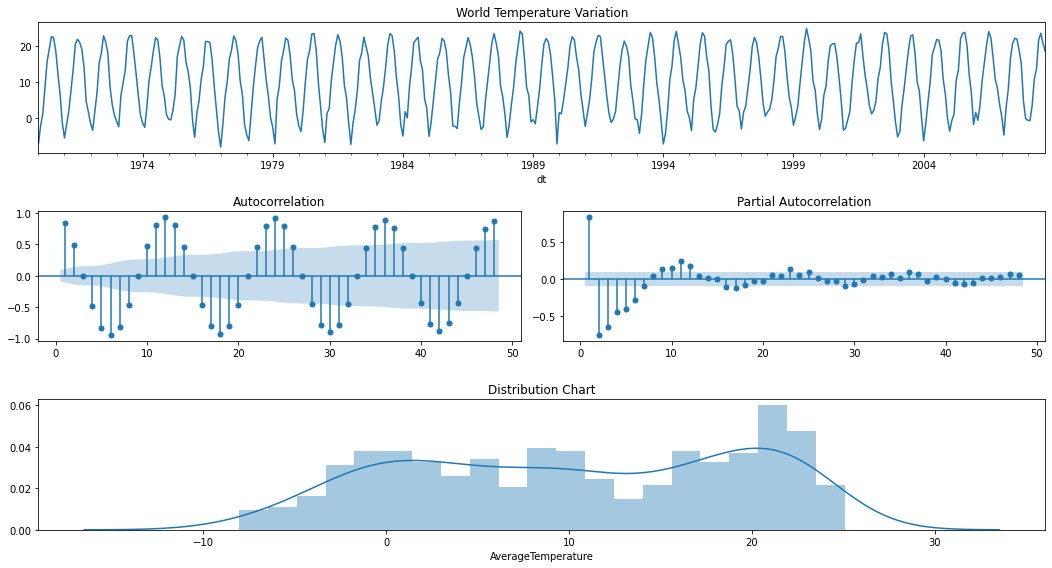

In [28]:
check_stationarity(train.set_index('dt')['AverageTemperature'])

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 6 and repeating each 12 months, it's because of the difference in the seasons

In [32]:
train['tmp_diff_12'] = train['AverageTemperature'].diff(12)

Results of Dickey-Fuller Test:
Test Statistic                 -10.8825
p-value                          0.0000
Lags Used                       11.0000
Number of Observations Used    429.0000
Critical Value (1%)             -3.4457
Critical Value (5%)             -2.8683
Critical Value (10%)            -2.5704
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The serie seems to be stationary


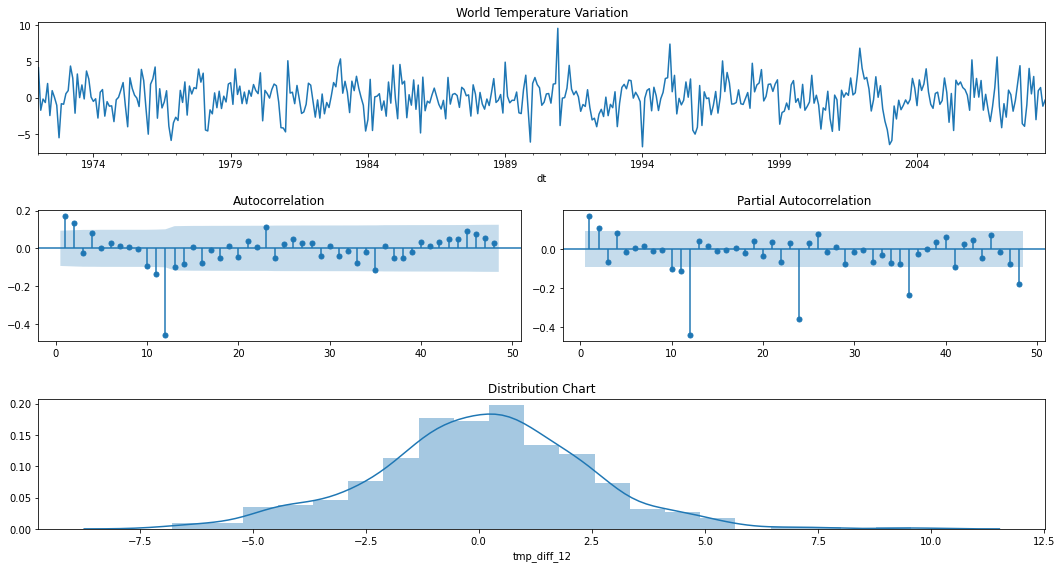

In [33]:
check_stationarity(train.set_index('dt')['tmp_diff_12'][24:])

* p  is most probably 2 since it is the last significant lag on the PACF, after which, most others are not significant.
* d  equals 0 because no difference to make our time series stationnary
* q  should be somewhere around 4 as well as seen on the ACF
* P  might be 4, since 12-th, 24-th, 36-th and 48-th lags are somewhat significant on the PACF
* D  again equals 1 because we performed seasonal differentiation
* Q  is probably 1. The 12-th lag on ACF is significant while the 24-th is not.

In [34]:
from itertools import product 

# setting initial values and some bounds for them
ps = range(2, 4)
d=1 
qs = range(3, 5)
Ps = range(3, 5)
D=1 
Qs = range(1, 3)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

**Optimize parameters for SARIMA**

In [36]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train.set_index('dt')['AverageTemperature'].values, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [69]:
result_table

,parameters,aic
0,"(3, 3, 3, 1)",2210.007164
1,"(3, 3, 3, 2)",2212.825324
2,"(2, 3, 4, 1)",2213.956765
3,"(2, 4, 3, 1)",2215.117814
4,"(2, 3, 3, 1)",2215.260928
5,"(2, 4, 4, 1)",2215.577473
6,"(3, 3, 4, 1)",2215.812181
7,"(2, 4, 4, 2)",2216.463399
8,"(3, 4, 4, 1)",2217.555584
9,"(2, 3, 4, 2)",2218.362368


**Keep the best model**

In [72]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(train.set_index('dt')['AverageTemperature'].values, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=False)
print(best_model.summary())

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  585
Model:             SARIMAX(3, 1, 3)x(3, 1, [1], 12)   Log Likelihood               -1094.004
Date:                              Wed, 07 Oct 2020   AIC                           2210.007
Time:                                      15:54:11   BIC                           2257.848
Sample:                                           0   HQIC                          2228.670
                                              - 585                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6688      0.036    -46.038      0.000      -1.740      -1.598
ar.L2         -0.72

**Prediction**

In [78]:
def walk_forward(training_set, validation_set, result_table):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    p, q, P, Q = result_table.parameters[0]

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model=sm.tsa.statespace.SARIMAX(history, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s))
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [79]:
val['Pred'] = walk_forward(train.set_index('dt')['AverageTemperature'], val.set_index('dt')['AverageTemperature'], result_table)

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sang-hoon/anaconda3/envs/minuteme/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/sang-hoon/anaconda3/envs/minuteme

**Performance measure RMSE**

In [84]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['AverageTemperature'], val['Pred'])

print(f"The RMSE of the SARIMA model was {round(rmse_pred,4)} celsius degrees")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")


The RMSE of the SARIMA model was 1.4635 celsius degrees
It's a decrease of -70.18% in the RMSE


In [87]:
# Creating the error column
val['Error'] = val['AverageTemperature'] - val['Pred']

**Analyze results**

In [88]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [91]:
val.head()

,dt,AverageTemperature,Pred,Error
3179,2008-10-01,10.348,11.980839,-1.632839
3180,2008-11-01,5.133,5.828635,-0.695635
3181,2008-12-01,0.327,0.190760,0.136240
3182,2009-01-01,-5.360,-3.110720,-2.249280
3183,2009-02-01,-0.372,-0.869861,0.497861


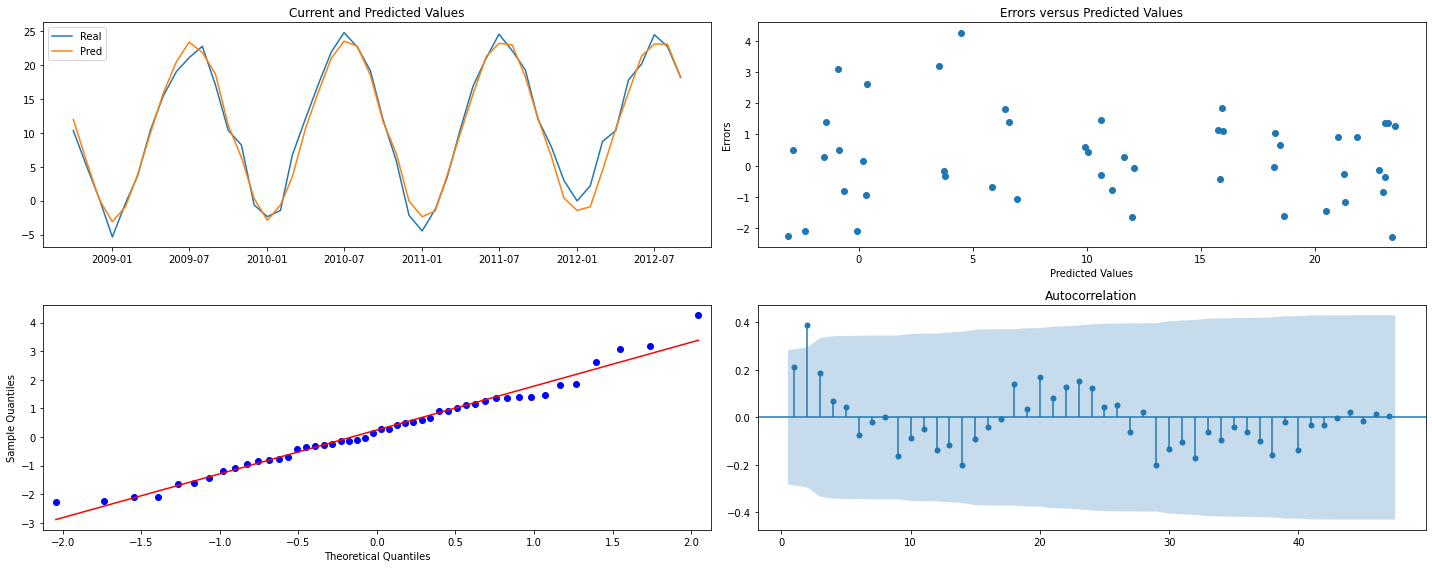

In [92]:
plot_error(val.set_index('dt'))

In [38]:
# TO DO: Predict for test set